Using Word2Vec, we can cluster the heroes according to their roles, using only the drafts as input.

In [1]:
import requests
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
h = requests.get("https://api.opendota.com/api/heroes").json()
hero_df = pd.DataFrame(h)
hero_df = hero_df.drop(hero_df.index[-1])

In [3]:
def import_the_data():
    infile = open('X_big','rb')
    X = pickle.load(infile)
    infile.close()
    infile = open('y_big','rb')
    y = pickle.load(infile)
    infile.close()
    return X,y

In [4]:
X, y = import_the_data()

WORD2VEC: Have a picked hero, want to predict the other 4 heroes.

In [5]:
def split_X_to_ignore_team(X):
    X1 = X[:,:116]
    X2 = X[:, 116:]
    X = np.concatenate((X1,X2), axis = 0)
    return X

In [6]:
X= split_X_to_ignore_team(X)

Let's restrict to 10,000 matches.

In [7]:
X_tot = X[:10000, :]

Create (input, context) pairs; we will use the simplest word2vec form, with one hero as input and one hero as context (repeat for every hero the input has in his team):

In [8]:
def input_context(X):
    inputs = np.zeros((X.shape[0]*5, X.shape[1]))
    contexts = np.zeros_like(inputs)
    for i in tqdm_notebook(range(X.shape[0])):
        counter = 0
        for j in range(X.shape[1]):
            if X[i,j] == 1:
                inputs[5*i + counter, j] += 1
                contexts[5*i + counter] = X[i] - inputs[5*i+counter]
                counter += 1
    return inputs, contexts
    
def one_to_one(inp, cont):
    new_inp = np.zeros((inp.shape[0]*4,inp.shape[1]))
    new_cont = np.zeros_like(new_inp)
    for i in tqdm_notebook(range(inp.shape[0])):
        counter = 0
        nonzeroes = np.nonzero(cont[i])[0]
        for mult in range(4):
            idx = int(nonzeroes[mult])
            new_inp[4*i + mult] = inp[i]
            new_cont[4*i + mult,idx] += 1
    return new_inp, new_cont
                
            

In [9]:
inputs, contexts = input_context(X_tot)
inp, cont = one_to_one(inputs, contexts)

In [10]:
def create_xy(inputs, contexts):
    N = inputs.shape[0]
    N1 = int(N*0.9)
    X_train = inputs[:N1]
    X_val = inputs[N1:]
    y_train = contexts[:N1]
    y_val = contexts[N1:]
    return X_train, y_train, X_val, y_val

In [11]:
X_train, y_train, X_val, y_val = create_xy(inp, cont)

In [12]:
from tensorflow import keras

In [13]:
Embedding_size = 100

In [14]:
model = keras.Sequential([
    keras.layers.Dense(Embedding_size, input_dim = X.shape[1], activation = 'tanh'),
    keras.layers.Dense(X.shape[1], activation = 'sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               11700     
_________________________________________________________________
dense_1 (Dense)              (None, 116)               11716     
Total params: 23,416
Trainable params: 23,416
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train, 
                              validation_data = (X_val,y_val),
                              batch_size = 100,
                              epochs=5,
                              shuffle = True,)

Train on 180000 samples, validate on 20000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
180000/180000 [==============================] - 12s 68us/sample - loss: 4.5150 - acc: 0.0344 - val_loss: 4.4734 - val_acc: 0.0342
Epoch 2/5
180000/180000 [==============================] - 12s 68us/sample - loss: 4.4620 - acc: 0.0370 - val_loss: 4.4582 - val_acc: 0.0427
Epoch 3/5
180000/180000 [==============================] - 13s 69us/sample - loss: 4.4507 - acc: 0.0394 - val_loss: 4.4581 - val_acc: 0.0423
Epoch 4/5
180000/180000 [==============================] - 13s 70us/sample - loss: 4.4453 - acc: 0.0397 - val_loss: 4.4574 - val_acc: 0.0417
Epoch 5/5
180000/180000 [==============================] - 13s 72us/sample - loss: 4.4416 - acc: 0.0399 - val_loss: 4.4596 - val_acc: 0.0421


In [41]:
weights = model.layers[0].get_weights()[0]

In [60]:
def distance(v,u):
    return np.linalg.norm(v-u)

def k_nearest_neighbors(idx,k,weights):
    distances = np.zeros(116)
    for i in range(weights.shape[0]):
        distances[i] += distance(weights[idx],weights[i])
    nbors = np.argsort(distances)
    nbors = nbors[1:(k+1)]
    return nbors

In [80]:
def nearest_heroes(hero, k, weights):
    idx = hero_df[hero_df['localized_name']==hero].index[0]
    nbors = k_nearest_neighbors(idx, k, weights)
    heroes = []
    for i in range(nbors.shape[0]):
        heroes.append(hero_df.iloc[int(nbors[i])]['localized_name'])
    return heroes

Sanity check:

In [86]:
nearest_heroes('Invoker', 5, weights)  # expect pos 2 heroes

['Shadow Fiend', 'Tinker', 'Outworld Devourer', 'Pugna', 'Zeus']

In [87]:
nearest_heroes('Crystal Maiden', 5, weights) # expect pos 5 heroes

['Keeper of the Light', 'Warlock', 'Ancient Apparition', 'Dazzle', 'Lion']

We want to visualise this - use t-SNE:

In [88]:
from sklearn.manifold import TSNE

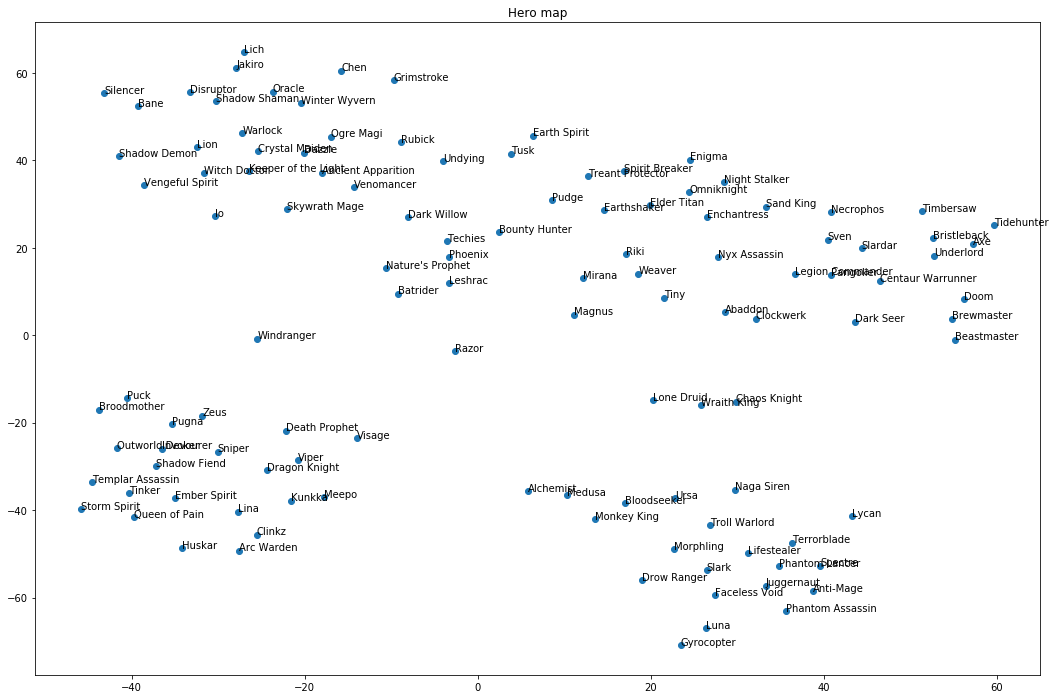

In [150]:
heroes_embedded = TSNE(n_components=2, perplexity = 10).fit_transform(weights)

names = hero_df['localized_name'].tolist()
x = np.reshape(heroes_embedded[:,0], (-1,1))
y = np.reshape(heroes_embedded[:,1], (-1,1))

fig, ax = plt.subplots(figsize = (18,12))

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]))

ax.scatter(x, y)
plt.title('Hero map');

We have a clear position 1 cluster, a clear position 2 cluster, and a cloud of positions 3-4-5, starting with 5 in the left and gradually transitioning to 3 in the right.